In [3]:
import os

import numpy as np
import pandas as pd

import datetime
import time

import random

# For plotting
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

In [4]:
def generate_customer_profiles_table(n_customers, random_state=0):
    
    np.random.seed(random_state)
        
    customer_id_properties=[]
    
    # Generate customer properties from random distributions 
    for customer_id in range(n_customers):
        
        x_customer_id = np.random.uniform(0,100)
        y_customer_id = np.random.uniform(0,100)
        
        mean_amount = np.random.uniform(5,100) # Arbitrary (but sensible) value 
        std_amount = mean_amount/2 # Arbitrary (but sensible) value
        
        mean_nb_tx_per_day = np.random.uniform(0,4) # Arbitrary (but sensible) value 
        
        customer_id_properties.append([customer_id,
                                      x_customer_id, y_customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])
        
    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'x_customer_id', 'y_customer_id',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])
    
    return customer_profiles_table

In [5]:
n_customers = 5
customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
customer_profiles_table

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day
0,0,54.881350,71.518937,62.262521,31.131260,2.179533
1,1,42.365480,64.589411,46.570785,23.285393,3.567092
2,2,96.366276,38.344152,80.213879,40.106939,2.115580
3,3,56.804456,92.559664,11.748426,5.874213,0.348517
4,4,2.021840,83.261985,78.924891,39.462446,3.480049


In [6]:
def generate_terminal_profiles_table(n_terminals, random_state=0):
    
    np.random.seed(random_state)
        
    terminal_id_properties=[]
    
    # Generate terminal properties from random distributions 
    for terminal_id in range(n_terminals):
        
        x_terminal_id = np.random.uniform(0,100)
        y_terminal_id = np.random.uniform(0,100)
        
        terminal_id_properties.append([terminal_id,
                                      x_terminal_id, y_terminal_id])
                                       
    terminal_profiles_table = pd.DataFrame(terminal_id_properties, columns=['TERMINAL_ID',
                                                                      'x_terminal_id', 'y_terminal_id'])
    
    return terminal_profiles_table

In [7]:
n_terminals = 5
terminal_profiles_table = generate_terminal_profiles_table(n_terminals, random_state = 0)
terminal_profiles_table

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


In [9]:
def get_list_terminals_within_radius(customer_profile, x_y_terminals, r):
    
    # Use numpy arrays in the following to speed up computations
    
    # Location (x,y) of customer as numpy array
    x_y_customer = customer_profile[['x_customer_id','y_customer_id']].values.astype(float)
    
    # Squared difference in coordinates between customer and terminal locations
    squared_diff_x_y = np.square(x_y_customer - x_y_terminals)
    
    # Sum along rows and compute suared root to get distance
    dist_x_y = np.sqrt(np.sum(squared_diff_x_y, axis=1))
    
    # Get the indices of terminals which are at a distance less than r
    available_terminals = list(np.where(dist_x_y<r)[0])
    
    # Return the list of terminal IDs
    return available_terminals
    

In [10]:
# We first get the geographical locations of all terminals as a numpy array
x_y_terminals = terminal_profiles_table[['x_terminal_id','y_terminal_id']].values.astype(float)
# And get the list of terminals within radius of $50$ for the last customer
get_list_terminals_within_radius(customer_profiles_table.iloc[4], x_y_terminals=x_y_terminals, r=50)

[2, 3]

In [11]:
terminal_profiles_table

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,54.881350,71.518937
1,1,60.276338,54.488318
2,2,42.365480,64.589411
3,3,43.758721,89.177300
4,4,96.366276,38.344152


In [12]:
%%capture

terminals_available_to_customer_fig, ax = plt.subplots(figsize=(5,5))

# Plot locations of terminals
ax.scatter(terminal_profiles_table.x_terminal_id.values, 
           terminal_profiles_table.y_terminal_id.values, 
           color='blue', label = 'Locations of terminals')

# Plot location of the last customer
customer_id=4
ax.scatter(customer_profiles_table.iloc[customer_id].x_customer_id, 
           customer_profiles_table.iloc[customer_id].y_customer_id, 
           color='red',label="Location of last customer")

ax.legend(loc = 'upper left', bbox_to_anchor=(1.05, 1))

# Plot the region within a radius of 50 of the last customer
circ = plt.Circle((customer_profiles_table.iloc[customer_id].x_customer_id,
                   customer_profiles_table.iloc[customer_id].y_customer_id), radius=50, color='g', alpha=0.2)
ax.add_patch(circ)

fontsize=15

ax.set_title("Green circle: \n Terminals within a radius of 50 \n of the last customer")
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
    
ax.set_xlabel('x_terminal_id', fontsize=fontsize)
ax.set_ylabel('y_terminal_id', fontsize=fontsize)

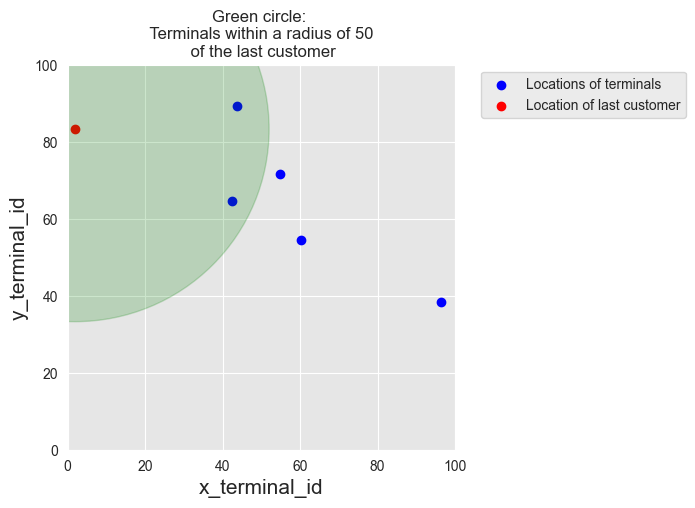

In [13]:
terminals_available_to_customer_fig

In [ ]:
customer_profiles_table['available_terminals']=customer_profiles_table.apply(lambda x : get_list_terminals_within_radius(x, x_y_terminals=x_y_terminals, r=50), axis=1)
customer_profiles_table

In [ ]:
def generate_transactions_table(customer_profile, start_date = "2023-04-01", nb_days = 10):
    
    customer_transactions = []
    
    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))
    
    # For all days
    for day in range(nb_days):
        
        # Random number of transactions for that day 
        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)
        
        # If nb_tx positive, let us generate transactions
        if nb_tx>0:
            
            for tx in range(nb_tx):
                
                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that 
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))
                
                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):
                    
                    # Amount is drawn from a normal distribution  
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)
                    
                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)
                    
                    amount=np.round(amount,decimals=2)
                    
                    if len(customer_profile.available_terminals)>0:
                        
                        terminal_id = random.choice(customer_profile.available_terminals)
                    
                        customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID, 
                                                      terminal_id, amount])
            
    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT'])
    
    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'TERMINAL_ID', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]
    
    return customer_transactions  
    
    